In [1]:
import math
import pandas as pd
import cv2
import numpy as np
import torch
from torch import nn
from torch import optim
from matplotlib import pyplot as plt

# Stitching

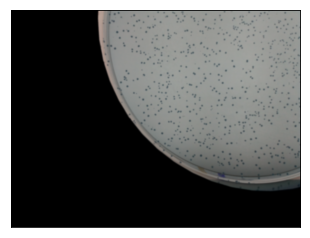

In [2]:
TL = cv2.imread("Plate Images/2019-07-16_15.40.51/Camera-3/4/image-00000.jpg")
TR = cv2.imread("Plate Images/2019-07-16_15.40.51/Camera-2/4/image-00000.jpg")
BL = cv2.imread("Plate Images/2019-07-16_15.40.51/Camera-1/4/image-00000.jpg")
BR = cv2.imread("Plate Images/2019-07-16_15.40.51/Camera-0/4/image-00000.jpg")
plt.imshow(BL, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [3]:
def stitch(toStitch,shape,overlap):
    #crop the images
    toStitch = crop(toStitch,overlap)
    #stitch them together
    stitched =list()
    for img in range(len(toStitch[0])):
        xStitched = list()
        for x in range(shape[0]-1):
            xStitched = list()
            for y in range(shape[1]):
                concat = np.concatenate((toStitch[x+y*shape[0]][img],toStitch[x+y*shape[0]+1][img]),axis=0)
                xStitched.append(concat)
        concat = [[0]]
        for y in range(shape[1]-1):
            concat = np.concatenate((xStitched[y],xStitched[y+1]),axis=1)
        stitched.append(concat)
    if shape == [1,1]:
        return toStitch[0]
    else:
        return stitched
def testStitch(toStitch,shape,overlap):
    #crop the images
    toStitch = crop(toStitch,overlap)
    #stitch them together
    stitched =list()
    for img in range(len(toStitch[0])):
        xStitched = list()
        for x in range(shape[0]-1):
            xStitched = list()
            for y in range(shape[1]):
                concat = np.concatenate((toStitch[x+y*shape[0]][img],toStitch[x+y*shape[0]+1][img]),axis=0)
                xStitched.append(concat)
        cv2.namedWindow("0", cv2.WINDOW_NORMAL)
        cv2.imshow('0',xStitched[0])
        cv2.namedWindow("1", cv2.WINDOW_NORMAL)
        cv2.imshow('1',xStitched[1])
        cv2.waitKey(0)
        concat = [[0]]
        for y in range(shape[1]-1):
            concat = np.concatenate((xStitched[y],xStitched[y+1]),axis=1)
        stitched.append(concat)
    return stitched
def crop(toStitch, overlap):
    pixelOverlap = (overlap[0]*toStitch[0][0].shape[0],overlap[1]*toStitch[0][0].shape[1])
    cropped = list()
    for cam in range(len(toStitch)):
        perCam = list()
        for i in range(len(toStitch[cam])):
            perCam.append(toStitch[cam][i][0:int(toStitch[cam][i].shape[1]-(pixelOverlap[1]/2)),0:int(toStitch[cam][i].shape[0]-(pixelOverlap[0]/2))])
        cropped.append(perCam)
    return cropped

In [4]:
toStitch = [[TL],[BL],[TR],[BR]]
res = stitch(toStitch,(2,2),(0,0))
def showImages(images):
    count = 0
    for img in images:
        windowName = "img" + str(count)
        cv2.namedWindow(windowName, cv2.WINDOW_NORMAL)
        cv2.imshow(windowName,img)
        cv2.waitKey(0)
        count += 1
    cv2.destroyAllWindows()
showImages(res)

# Binary Mask

In [5]:
plateImage = cv2.imread("Plate Images/image-00000.jpg",0)
print(type(plateImage))

<class 'numpy.ndarray'>


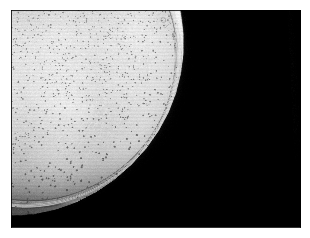

In [6]:
plt.imshow(plateImage, 'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

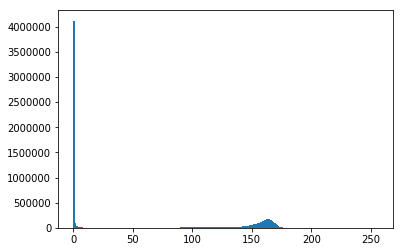

In [7]:
 plt.hist(plateImage.ravel(),256,[0,256]); plt.show()

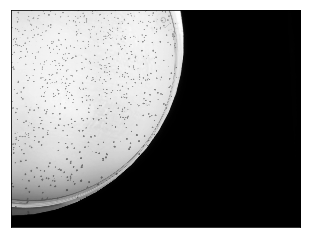

In [8]:
# Denoising the vertical black lines 
image = cv2.fastNlMeansDenoising(plateImage,None,10,7,21)
plt.imshow(image, 'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

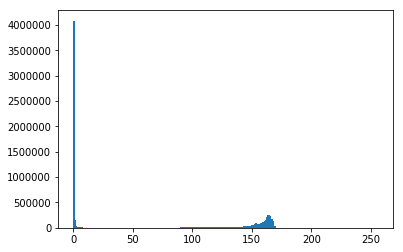

In [9]:
 plt.hist(image.ravel(),256,[0,256]); plt.show()

In [10]:
titles = ['Original Image', 'Noise Reuction']
images = [plateImage, image]
showImages(images)

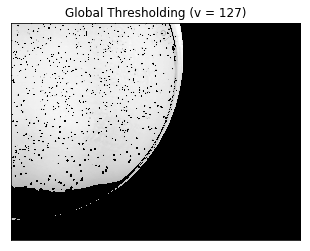

In [11]:
ret,th1 = cv2.threshold(image,127,255,cv2.THRESH_TOZERO)
plt.imshow(th1, 'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.title("Global Thresholding (v = 127)")
plt.show()

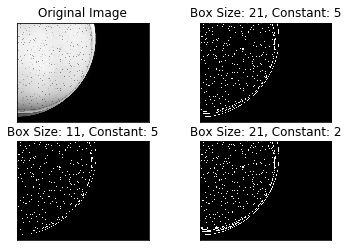

In [12]:
b1 = 21; c1 =5; 
b2 = 11; c2 = 5; 
b3 = 21; c3 = 2; 
adapMean1 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,b1, c1)
adapMean2 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,b2, c2)
adapMean3 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,b3, c3) 

titles = ['Original Image', 'Box Size: ' + str(b1) + ', Constant: ' + str(c1),
            'Box Size: ' + str(b2) + ', Constant: ' + str(c2), 'Box Size: ' + str(b3) + ', Constant: ' + str(c3)]
images = [image, adapMean1, adapMean2, adapMean3]

showImages(images)

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

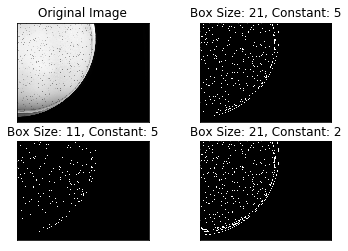

In [13]:
b1 = 21; c1 = 5; 
b2 = 11; c2 = 5; 
b3 = 21; c3 = 2; 
adapGauss1 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,b1, c1)
adapGauss2 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,b2, c2)
adapGauss3 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, b3, c3) 

titles = ['Original Image', 'Box Size: ' + str(b1) + ', Constant: ' + str(c1),
            'Box Size: ' + str(b2) + ', Constant: ' + str(c2), 'Box Size: ' + str(b3) + ', Constant: ' + str(c3)]
images = [image, adapGauss1, adapGauss2, adapGauss3]

showImages(images)

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [14]:
# global thresholding
ret1,th1 = cv2.threshold(image,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(image,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(ret1)
print(ret2)
print(ret3)

127.0
76.0
76.0


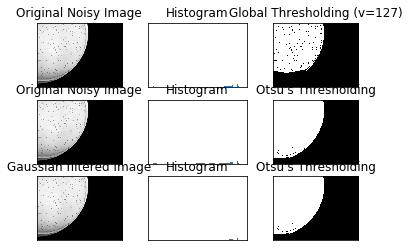

In [15]:
# plot all the images and their histograms
imgs = [image,th1, th2, th3]
images = [image, 0, th1,
          image, 0, th2,
          image, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

showImages(imgs)
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

In [16]:
showImages([adapGauss3])

# Blob Detection

In [17]:
# Setup SimpleBlobDetector parameters.
params0 = cv2.SimpleBlobDetector_Params()
params0.filterByColor = True
params0.blobColor = 255

params1 = cv2.SimpleBlobDetector_Params()
params1.filterByColor = True
params1.blobColor = 255
params1.filterByInertia = True
params1.minInertiaRatio = 0.01
params1.filterByConvexity = True
params1.minConvexity = 0.01

params2 = cv2.SimpleBlobDetector_Params()
params2.filterByColor = True
params2.blobColor = 255
params2.filterByInertia = True
params2.minInertiaRatio = 0.01
params2.filterByConvexity = True
params2.minConvexity = 0.9

paramList = [params0, params1, params2]
detectorList = []

is_v2 = cv2.__version__.startswith("2.")
if is_v2:
    for params in paramList:        
        detector = cv2.SimpleBlobDetector(params)
        detectorList.append(detector)
else:
    for params in paramList:        
        detector = cv2.SimpleBlobDetector_create(params)
        detectorList.append(detector)

In [ ]:
keypointImages = []
for detector in detectorList:
    keypoints = detector.detect(adapGauss3)
    print(len(keypoints))
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    binaryKeypoints = cv2.drawKeypoints(adapGauss3, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    originalKeypoints = cv2.drawKeypoints(image, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    keypointImages.append(binaryKeypoints)
    keypointImages.append(originalKeypoints)
showImages(keypointImages)

640
757
712


# Dark Area Approach

## Segmentation

In [19]:
def dist(p1, p2):
    return math.sqrt((p2[0] -  p1[0])**2 + (p2[1] - p1[1])**2)

In [20]:
class Blob:
    def __init__(self, coord, whitePix, darkPix):
        self.coord = coord
        self.whitePix = whitePix
        self.darkPix = darkPix

In [21]:
len(adapGauss3[0])

3280

In [22]:
R = 32
phi = 0.1
keyPoints = detectorList[2].detect(adapGauss3)
width = len(adapGauss3)
height = len(adapGauss3[0])
blobList = []
for keyPoint in keyPoints:
    # Obtaining the x,y pixel coordinates of the blob
    x = (int) (keyPoint.pt[0])
    y = (int) (keyPoint.pt[1])
    coord = [x, y]
    # Starting x and y coordinates for the segmented box
    lowX = x - R
    lowY = y - R
    
    # discarding blobs too close to window boundaries
    if lowX < 0 or lowY < 0 or lowX + 2*R > width or lowY + 2*R > height: 
        continue 
    r = (int) (keyPoint.size * (1+phi))/2
    # dark percentage inside = darkCount/insideCount
    # white percentage outside = whiteCOunt/outsideCount
    insideCount = 0
    outsideCount = 0
    whiteCount = 0
    darkCount = 0
    for i in range(lowX, lowX + 2*R):
        for j in range (lowY, lowY + 2*R):
            # Do not count pixels that are outside larger circle
            if dist([x,y], [i,j]) >= R:
                continue
            # Check for dark pixels inside blob
            elif dist([x,y], [i,j]) <= r: 
                insideCount += 1
                if adapGauss3[j, i] == 0:
                    darkCount += 1
            # Check for white pixels outside blob
            else:
                outsideCount += 1
                if adapGauss3[j, i] == 255: 
                    whiteCount += 1
    whitePix = whiteCount*100/outsideCount
    darkPix = darkCount*100/insideCount
    blobList.append(Blob(coord, whitePix, darkPix))
        
print(len(blobList))

679


## Analysis

In [23]:
# Ranking for worst single colonies
whiteRank = sorted(blobList, key=lambda x: x.whitePix, reverse = True)
# Ranking for worst separation from neighbors
darkRank = sorted(blobList, key=lambda x: x.darkPix, reverse = True)

In [24]:
# Worst single colonies
for i in range(10):
    print(f"WhitePix: {darkRank[i].whitePix} DarkPix: {darkRank[i].darkPix}")
segList = []
imgList = []
for blob in darkRank[:10]:
    lowX = blob.coord[0] - 32
    lowY = blob.coord[1] - 32
    segment = keypointImages[2][lowY: lowY + 64, lowX: lowX + 64]
    segList.append(segment)
showImages(segList)

WhitePix: 25.79719387755102 DarkPix: 42.028985507246375
WhitePix: 25.573979591836736 DarkPix: 40.57971014492754
WhitePix: 18.314321926489228 DarkPix: 38.775510204081634
WhitePix: 8.033240997229917 DarkPix: 32.49211356466877
WhitePix: 8.053221288515406 DarkPix: 31.80515759312321
WhitePix: 2.9813218390804597 DarkPix: 26.60332541567696
WhitePix: 6.073825503355705 DarkPix: 24.444444444444443
WhitePix: 0.9342301943198804 DarkPix: 24.00756143667297
WhitePix: 0.9958791208791209 DarkPix: 21.160409556313994
WhitePix: 11.212737127371273 DarkPix: 19.76284584980237


In [25]:
# Worst separated colonies
for i in range(10):
    print(f"WhitePix: {whiteRank[i].whitePix} DarkPix: {whiteRank[i].darkPix}")
segList = []
imgList = []
for blob in whiteRank[:10]:
    lowX = blob.coord[0] - 32
    lowY = blob.coord[1] - 32
    segment = keypointImages[2][lowY: lowY + 64, lowX: lowX + 64]
    segList.append(segment)
showImages(segList)

WhitePix: 34.109042553191486 DarkPix: 8.629441624365482
WhitePix: 31.890581717451525 DarkPix: 14.195583596214512
WhitePix: 30.61426684280053 DarkPix: 12.429378531073446
WhitePix: 25.79719387755102 DarkPix: 42.028985507246375
WhitePix: 25.664893617021278 DarkPix: 11.16751269035533
WhitePix: 25.573979591836736 DarkPix: 40.57971014492754
WhitePix: 24.51923076923077 DarkPix: 11.604095563139932
WhitePix: 23.91017173051519 DarkPix: 4.519774011299435
WhitePix: 22.9739010989011 DarkPix: 9.215017064846416
WhitePix: 22.972972972972972 DarkPix: 2.0618556701030926


In [26]:
whitePixData = [blob.whitePix for blob in blobList]
darkPixData = [blob.darkPix for blob in blobList]

In [27]:
whiteDF = pd.DataFrame(whitePixData)
whiteDF.describe()

,0
count,679.000000
mean,4.722074
std,5.259219
min,0.097784
25%,0.585246
50%,2.792553
75%,7.374710
max,34.109043


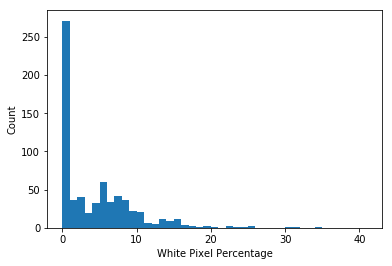

In [28]:
plt.hist(whitePixData,41,[0,41]) 
plt.xlabel("White Pixel Percentage")
plt.ylabel("Count")
plt.show()

In [29]:
darkDF = pd.DataFrame(darkPixData)
darkDF.describe()

,0
count,679.000000
mean,9.556733
std,4.325577
min,0.000000
25%,7.106599
50%,9.395973
75%,11.673526
max,42.028986


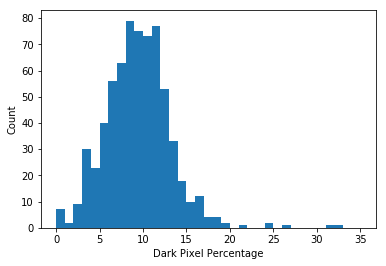

In [30]:
plt.hist(darkPixData,35,[0,35]) 
plt.xlabel("Dark Pixel Percentage")
plt.ylabel("Count")
plt.show()

## Scaling 

In [31]:
# Waiting for stiched image to be aligned 

## Exporting

In [32]:
coordExport = pd.DataFrame(coordList, columns=["X", "Y"])
coordExport.to_csv (r'locations.csv', index = None, header= False)

NameError: name 'coordList' is not defined

In [ ]:
coordExport.head()

# Deep Learning Approach 

## Segmentation

In [ ]:
# keyPoints = detectorList[2].detect(adapGauss3)
# count = 0
# for keyPoint in keyPoints:
#     x = keyPoint.pt[0]
#     y = keyPoint.pt[1]
#     topX = (int)(x - 64) 
#     topY = (int) (y - 64)
#     if topX < 0 or topY < 0: 
#         continue 
#     segment = adapGauss3[topY: topY + 128, topX: topX + 128]
#     fileName = 'TrainImages/TrainImage' + str(count) + '.png'
#     cv2.imwrite(fileName, segment)
#     count += 1
# #     print('{},{}'.format(x, y))
# #     print('{},{}'.format(topX, topY))
# #     print(keyPoint.size)
# #     showImages([segment])
# print(count) 
    

## Convolutional Nerual Network

In [ ]:
# import torch.cuda as cuda

# # Use a GPU, i.e. cuda:0 device if it available.
# device = torch.device("cuda:0" if cuda.is_available() else "cpu")
# print(device)